In [199]:
import subprocess
from unicorn import *
from unicorn.riscv_const import *

In [200]:
o_filename = './for_opt.o'
s = subprocess.check_output(["riscv64-unknown-linux-gnu-objcopy", o_filename, '/dev/null', '--dump-section', '.text=text.data'])
with open('text.data', 'rb') as f:
    text_hex = f.read()
text_hex

b'9q"\xfc&\xf8J\xf4N\xf0R\xec\x80\x00\xb7\x07\x00\x00\x93\x87\x07\x00\x98c#0\xe4\xfc\x9cg#4\xf4\xfc\x81I\x11J\x01I=\xa8\xca\x84\x05\t\x93\x97$\x00\x93\x87\x07\xfd\xa2\x97\x83\xa7\x07\xff\xbb\x87\xf9\x00\x9b\x89\x07\x00\x93\x97$\x00\x93\x87\x07\xfd\xa2\x97\x83\xa7\x07\xff\x85\'\x1b\x87\x07\x00\x93\x97$\x00\x93\x87\x07\xfd\xa2\x97#\xa8\xe7\xfeJ\x87\xd2\x87\xe3@I\xfd\x01\x00\x01\x00bt\xc2t"y\x82ybj!a\x82\x80'

In [201]:
o_filename = './for_opt.o'
s = subprocess.check_output(["riscv64-unknown-linux-gnu-objcopy", o_filename, '/dev/null', '--dump-section', '.rodata=rodata.data'])
with open('rodata.data', 'rb') as f:
    rodata_hex = f.read()
rodata_hex

b'\x01\x00\x00\x00\x02\x00\x00\x00\x03\x00\x00\x00\x04\x00\x00\x00'

In [202]:
# o_filename = './bubble_sort.o'
# s = subprocess.check_output(["riscv64-unknown-linux-gnu-objcopy", o_filename, '/dev/null', '--dump-section', '.text=text.data'])
# with open('text.data', 'rb') as f:
#     text_hex = f.read()
# text_hex

In [203]:
# o_filename = './bubble_sort.o'
# s = subprocess.check_output(["riscv64-unknown-linux-gnu-objcopy", o_filename, '/dev/null', '--dump-section', '.rodata=rodata.data'])
# with open('rodata.data', 'rb') as f:
#     rodata_hex = f.read()
# rodata_hex

In [204]:
# o_filename = './insertion_sort.o'
# s = subprocess.check_output(["riscv64-unknown-linux-gnu-objcopy", o_filename, '/dev/null', '--dump-section', '.text=text.data'])
# with open('text.data', 'rb') as f:
#     text_hex = f.read()
# text_hex

In [205]:
# o_filename = './insertion_sort.o'
# s = subprocess.check_output(["riscv64-unknown-linux-gnu-objcopy", o_filename, '/dev/null', '--dump-section', '.rodata=rodata.data'])
# with open('rodata.data', 'rb') as f:
#     rodata_hex = f.read()
# rodata_hex

In [206]:
d = {i:[] for i in range(32)}
lastest_reg_used = [0] * 32

# memory address where emulation starts
ADDRESS    = 0x10000

STC_ADDRESS = 0x20000

distance_list = []

# callback for tracing instructions
def hook_code(uc, address, size, user_data):
    for i in range(32):
        lastest_reg_used[i] += 1
    
    inst = int.from_bytes(text_hex[address-ADDRESS:address-ADDRESS+size], 'little')
    if size == 4:
        opcode = inst & 0b1111111
        rs2 = (inst >> 20) & 0b11111
        rs1 = (inst >> 15) & 0b11111
        rd = (inst >> 7) & 0b11111
        
        # print(">>> Tracing branch instruction at 0x{:x}, instruction = 0x{:x}, rs2 = {}, rs1 = {}".format(address, inst, rs2, rs1))
        if opcode == 0x13:
            # print('At 0x{:x}, instruction = 0x{:x}  ALUI: rs1 = {}, rd = {}'.format(address, inst, rs1, rd))
            d[rd].append(address)
            lastest_reg_used[rd] = 0
        elif opcode == 0x03:
            # print('At 0x{:x}, instruction = 0x{:x}  LOAD: rs1 = {}, rd = {}'.format(address, inst, rs1, rd))
            d[rd].append(address)
            lastest_reg_used[rd] = 0
        elif opcode == 0x37:
            # print('At 0x{:x}, instruction = 0x{:x}  LUI: rd = {}'.format(address, inst, rd))
            d[rd].append(address)
            lastest_reg_used[rd] = 0
        elif opcode == 0x1b:
            # print('At 0x{:x}, instruction = 0x{:x}  ADDIW: rs1 = {}, rd = {}'.format(address, inst, rs1, rd))
            d[rd].append(address)
            lastest_reg_used[rd] = 0
        elif opcode == 0x63:
            # pass
            print('At 0x{:x}, instruction = 0x{:x}  COND.B: rs1 = {}, rs2 = {}, last_access = 0x{:x}  0x{:x}'.format(address, inst, rs1, rs2, d[rs1][-1], d[rs2][-1]))
            # print(lastest_reg_used)
            user_data += [lastest_reg_used[rs1], lastest_reg_used[rs2]]
            
        
    elif size == 2:
        opcode_1 = (inst >> 13) & 0b111
        opcode_2 = inst & 0b11
        
        if opcode_2 == 0b00:
            rs1 = ((inst >> 7) & 0b111) + 8 
            rd = ((inst >> 2) & 0b111) + 8 
            if opcode_1 == 0b011:
                # print('At 0x{:x}, instruction = 0x{:x}  C.LD: rs1 = {}, rd = {}'.format(address, inst, rs1, rd))
                d[rd].append(address)
                lastest_reg_used[rd] = 0
            if opcode_1 == 0b000:
                # print('At 0x{:x}, instruction = 0x{:x}  C.ADDI4SPN: rs1 = {}, rd = {}'.format(address, inst, 2, rd))
                d[rd].append(address)
                lastest_reg_used[rd] = 0
        elif opcode_2 == 0b01:
            rd = (inst >> 7) & 0b11111
            rs1 = (inst >> 7) & 0b11111
            if opcode_1 == 0b000:
                print('At 0x{:x}, instruction = 0x{:x}  C.ADDI: rs1 = {}, rd = {}'.format(address, inst, rs1, rd))
                d[rd].append(address)
                lastest_reg_used[rd] = 0
            elif opcode_1 == 0b100:
                rs2 = ((inst >> 2) & 0b111) + 8
                rd = ((inst >> 7) & 0b111) + 8
                rd = ((inst >> 7) & 0b111) + 8
                # print('At 0x{:x}, instruction = 0x{:x}  C.ADDW: rs1 = {}, rd = {}, rs = {}'.format(address, inst, rs1, rd, rs2))
                d[rd].append(address)
                lastest_reg_used[rd] = 0
            elif opcode_1 == 0b010:
                rd = (inst >> 7) & 0b11111
                # print('At 0x{:x}, instruction = 0x{:x}  C.LI:  rd = {}'.format(address, inst, rd))
                d[rd].append(address)
                lastest_reg_used[rd] = 0
        elif opcode_2 == 0b10:
            rs1 = (inst >> 7) & 0b11111
            rd = (inst >> 7) & 0b11111
            rs2 = (inst >> 2) & 0b11111
            if opcode_1 == 0b000:
                # print('At 0x{:x}, instruction = 0x{:x}  C.SLLI: rs1 = {}, rd = {}'.format(address, inst, rs1, rd))
                d[rd].append(address)
                lastest_reg_used[rd] = 0
            elif opcode_1 == 0b100:
                # print('At 0x{:x}, instruction = 0x{:x}  C.ADD: rs1 = {}, rd = {}, rs2 = {}'.format(address, inst, rs1, rd, rs2))
                d[rd].append(address)
                lastest_reg_used[rd] = 0
        elif opcode_2 == 0b11:
            print('Something Wrong when size = 2')
        

# Test RISCV
def test_riscv():
    print("Emulate RISCV code")
    try:
        # Initialize emulator in RISCV32 mode
        mu = Uc(UC_ARCH_RISCV, UC_MODE_RISCV64)
    
        # map 2MB memory for this emulation
        mu.mem_map(0x0, 2 * 1024 * 1024)
        
        # write machine code to be emulated to memory
        mu.mem_write(0x0, rodata_hex)
        
        mu.mem_write(ADDRESS, text_hex)

        # initialize machine registers
        mu.reg_write(UC_RISCV_REG_SP, STC_ADDRESS)
        
        mu.reg_write(UC_RISCV_REG_RA, ADDRESS + len(text_hex))

        # tracing all instructions with customized callback
        mu.hook_add(UC_HOOK_CODE, hook_code, distance_list)

        # emulate machine code in infinite time
        mu.emu_start(ADDRESS, ADDRESS + len(text_hex))
        # mu.emu_start(ADDRESS, ADDRESS + 0x24)
        
        sp = mu.reg_read(UC_RISCV_REG_SP)
        print(">>> SP = 0x%x" %sp)
        
        s0 = mu.reg_read(UC_RISCV_REG_S0)
        print(">>> S0 = 0x%x" %s0)
        
        a4 = mu.reg_read(UC_RISCV_REG_A4)
        print(">>> A4 = 0x%x" %a4)
        
        a5 = mu.reg_read(UC_RISCV_REG_A5)
        print(">>> A5 = 0x%x" %a5)

        print(int.from_bytes(mu.mem_read(STC_ADDRESS-40, 4), 'little'))
        
        print(int.from_bytes(mu.mem_read(STC_ADDRESS-36, 4), 'little'))
        
        print(int.from_bytes(mu.mem_read(STC_ADDRESS-32, 4), 'little'))
        
        print(int.from_bytes(mu.mem_read(STC_ADDRESS-28, 4), 'little'))
        
        print(int.from_bytes(mu.mem_read(STC_ADDRESS-24, 4), 'little'))
        
        print(int.from_bytes(mu.mem_read(STC_ADDRESS-20, 4), 'little'))

    except UcError as e:
        print("ERROR: %s" % e)
        
test_riscv()

Emulate RISCV code
At 0x1006a, instruction = 0xfd4940e3  COND.B: rs1 = 18, rs2 = 20, last_access = 0x10026  0x10024
At 0x1002c, instruction = 0x905  C.ADDI: rs1 = 18, rd = 18
At 0x1006a, instruction = 0xfd4940e3  COND.B: rs1 = 18, rs2 = 20, last_access = 0x1002c  0x10024
At 0x1002c, instruction = 0x905  C.ADDI: rs1 = 18, rd = 18
At 0x1006a, instruction = 0xfd4940e3  COND.B: rs1 = 18, rs2 = 20, last_access = 0x1002c  0x10024
At 0x1002c, instruction = 0x905  C.ADDI: rs1 = 18, rd = 18
At 0x1006a, instruction = 0xfd4940e3  COND.B: rs1 = 18, rs2 = 20, last_access = 0x1002c  0x10024
At 0x1002c, instruction = 0x905  C.ADDI: rs1 = 18, rd = 18
At 0x1006a, instruction = 0xfd4940e3  COND.B: rs1 = 18, rs2 = 20, last_access = 0x1002c  0x10024
At 0x1006e, instruction = 0x1  C.ADDI: rs1 = 0, rd = 0
At 0x10070, instruction = 0x1  C.ADDI: rs1 = 0, rd = 0
>>> SP = 0x20000
>>> S0 = 0x0
>>> A4 = 0x4
>>> A5 = 0x4
0
0
0
0
0
0


In [207]:
distance_list

[4, 5, 19, 26, 19, 47, 19, 68, 19, 89]

In [208]:
from collections import Counter
Counter(distance_list)

Counter({4: 1, 5: 1, 19: 4, 26: 1, 47: 1, 68: 1, 89: 1})

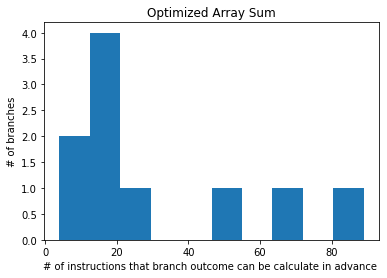

In [209]:
import matplotlib.pyplot as plt
plt.hist(distance_list)
plt.xlabel('# of instructions that branch outcome can be calculate in advance ')
plt.ylabel('# of branches')
plt.title('Optimized Array Sum')
plt.show() 